# Preparación del entorno

In [ ]:
!git clone https://github.com/josesanchfez-umu/k_brazos_SFDD.git
# Instalar librerías
!pip install numpy seaborn pandas matplotlib scikit-learn

In [ ]:
import os
os.chdir('k_brazos_SFDD')
print("Directorio actual:", os.getcwd())

In [ ]:
import sys

# Añadir los directorios fuentes al path de Python
sys.path.append('./src')


# Verificar que se han añadido correctamente
print(sys.path)

In [6]:
import numpy as np
from typing import List

from algorithms import Algorithm
from algorithms.ucb1 import UCB1
from algorithms.ucb2 import UCB2
from arms.armbinomial import ArmBinomial
from arms import Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret

# Experimento

In [7]:
seed = 42
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    optimal_reward = bandit.get_expected_value(optimal_arm) # Recompensa esperada del brazo óptimo.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz del rechazo acumulado

    arm_stats = [(algo, {arm: [0, 0] for arm in range(len(bandit.arms))}) for algo in algorithms] # TODO: Lista para almacenar estadísticas por cada algoritmo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        cumulative_regret = np.zeros(len(algorithms))   # Acumulador de rechazo acumulado por algoritmo.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # TODO: (arm_statistics) Buscar el conjunto de estadísticas correspondiente a este algoritmo
                _, stats = arm_stats[idx]
                # Registrar selecciones y recompensas en arm_stats
                stats[chosen_arm][0] += 1  # Contador de selecciones
                stats[chosen_arm][1] += reward  # Suma de recompensas

                #TODO: (optimal_selections) modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del rechazo
                regret = optimal_reward - reward  
                cumulative_regret[idx] += regret  # Acumular regret total
                regret_accumulated[idx, step] += cumulative_regret[idx] 


    rewards /= runs

    # TODO: (optimal_selections) calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    regret_accumulated /= runs  # Calcular el rechazo acumulado promedio

    # TODO: (arm_statistics) Calcular la recompensa promedio para cada brazo
    for _, stats in arm_stats:
        for arm in stats:
            selections, total_reward = stats[arm]
            stats[arm] = (selections, total_reward / selections if selections > 0 else 0)

    return rewards, optimal_selections, arm_stats, regret_accumulated

In [8]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 500  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos usando distribución binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

Bandit with 10 arms: ArmBinomial(n=11, p=0.22479561626896213), ArmBinomial(n=8, p=0.14646688973455957), ArmBinomial(n=17, p=0.7929409166199481), ArmBinomial(n=19, p=0.5808920093945671), ArmBinomial(n=15, p=0.6664580622368363), ArmBinomial(n=12, p=0.11646759543664197), ArmBinomial(n=17, p=0.8759278817295955), ArmBinomial(n=9, p=0.7659541126403374), ArmBinomial(n=11, p=0.26987128854262094), ArmBinomial(n=14, p=0.24545997376568052)
Optimal arm: 7 with expected reward=14.890773989403122


En el experimento que hemos realizado sobre la distribución binomial hemos considerado conveniente reducir los steps de ejecución debido a que a partir de 500 steps la información aportada en las gráficas es mínima ya que se mantiene exactamente la misma tendencia y dibujo de la gráfica que durante los primeros 500. Hemos probado a ejecutar el experimento en ambos casos y los resultados no varían, por lo que las conclusiones que obtenemos de un caso a otro son las mismas, con el añadido de que, al haber menos steps en unas gráficas que, ya adelantamos, presentan diferencias mínimas, dichas diferencias son bastante más visibles al haber menos steps temporales.

# UCB1

In [9]:
# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
ucb1_algorithms = [UCB1(k, c=0.5), UCB1(k, c=1.0), UCB1(k, c=2.0)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_UCB1, optimal_selections_UCB1, arm_stats_UCB1, regret_accumulated_UCB1 = run_experiment(bandit, ucb1_algorithms, steps, runs)

## Recompensa promedio

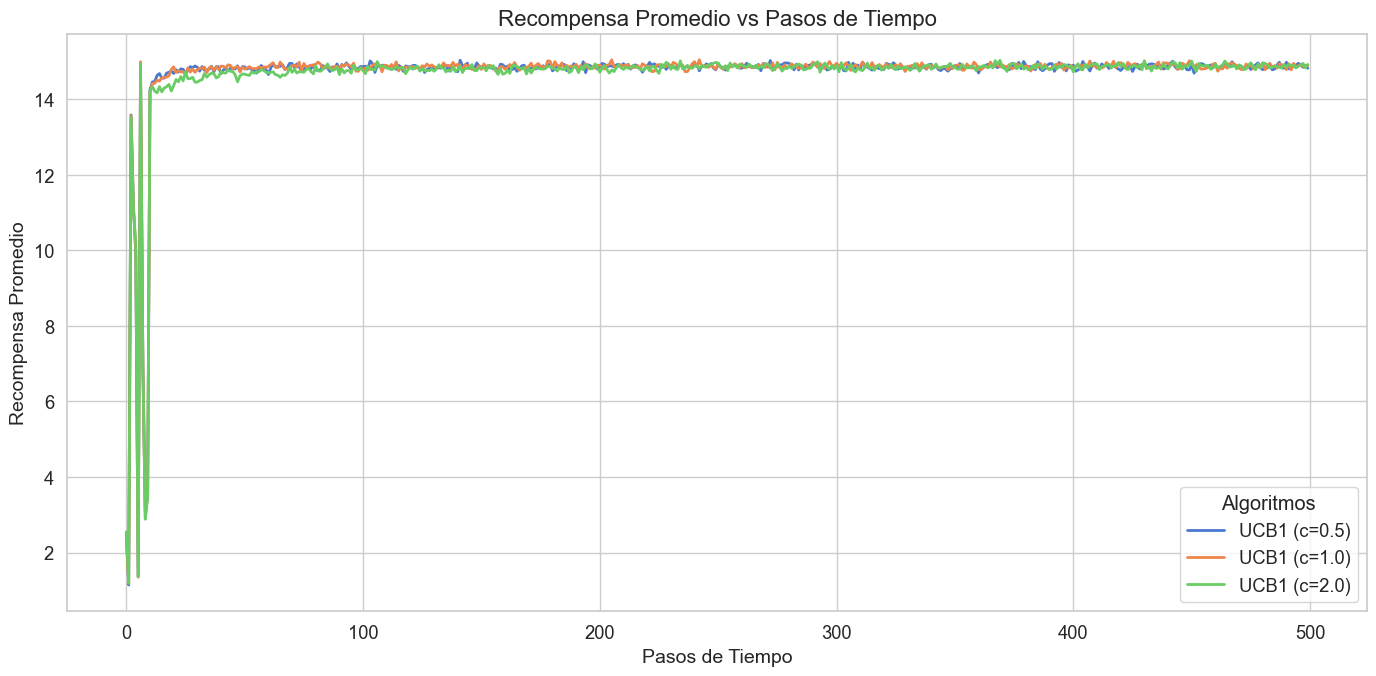

In [10]:
plot_average_rewards(steps, rewards_UCB1, ucb1_algorithms)

La gráfica anterior muestra la recompensa promedio obtenida por cada algoritmo en función del número de pasos. A nivel general, podemos indicar los siguientes hechos:

- Todas las variantes del algoritmo UCB1 (c=0.5, c=1.0 y c=2.0) convergen rápidamente hacia una recompensa promedio de aproximadamente 14.5. Esto sugiere que el algoritmo, independientemente del valor de c, logra identificar la mejor acción (o brazo) a lo largo del tiempo y maximizar la recompensa acumulada.

- Después de una fase inicial de fluctuaciones, todas las líneas se estabilizan y siguen una tendencia similar. Esto indica que, si bien c tiene un efecto en las fases iniciales, su impacto a largo plazo parece ser menos significativo en este experimento, a diferencia de lo que ocurre en otros casos como el del experimento con distribución Bernoulli.

- Hemos reducido en este estudio los steps temporales de 1000 a 500 ya que la gráfica no varía en el fragmento que va desde el paso 500 al 1000, y este nuevo valor permite visualizar algo mejor las pequeñas diferencias entre las variantes del algoritmo, como hemos mencionado en el apartado "Experimento".

**Resultados por algoritmo**

- La línea verde (c=2.0) muestra fluctuaciones iniciales más significativas, lo cual indica que con un mayor c, el algoritmo tiende a explorar más al principio antes de estabilizarse.

- Las líneas azul (c=0.5) y naranja (c=1.0) muestran un comportamiento más estable desde el principio, lo que podría sugerir una menor exploración inicial y, por consiguiente, un mejor resultado.

Dado que el experimento consiste en visualizar el rendimiento general obtenido por las variantes del mismo algoritmo, podemos decir que es más efectivo priorizar la explotación sobre la exploración al obtener mejor resultado con valores bajos del factor de exploración.

## Regret acumulado

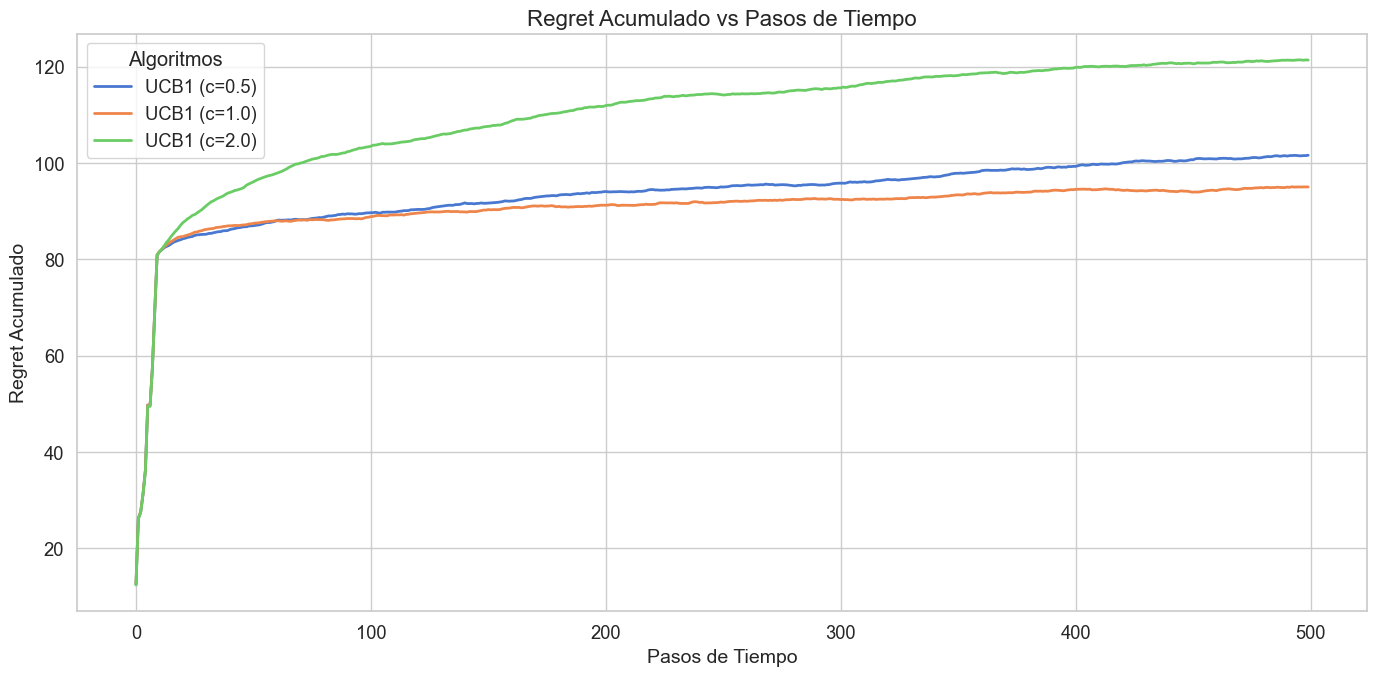

In [11]:
plot_regret(steps, regret_accumulated_UCB1, ucb1_algorithms)

La gráfica que visualizamos en este apartado es la de regret acumulado vs pasos de tiempo, en un formato similar al del apartado anterior. El objetivo de mostrar esta gráfica es visualizar una medida que indica la cantidad de oportunidad perdida por no explorar suficiente para elegir el brazo óptimo o explotarlo lo suficiente.

A niveles generales, podemos observar que de inicio, el valor regret es 0, pero crece a unos niveles excesivamente rápidos en muy pocos pasos, mostrando un rendimiento exactamente igual para los tres algoritmos. Sin embargo, justo después de superar el valor 80 de regret, las líneas divergen.

**Resultados por algoritmo**

- UCB1 con c=0.5 (Azul): Incrementa de manera moderada y consistente con el tiempo. Al alcanzar los 500 pasos de tiempo, el regret acumulado está alrededor de 100. Esto indica que la estrategia es relativamente equilibrada, con una mezcla adecuada de exploración y explotación.

- UCB1 con c=1.0 (Naranja): Muestra la tasa de crecimiento más lenta entre las tres variantes. Al final del intervalo (500 pasos de tiempo), el regret acumulado es ligeramente menor que 100. Esto demuestra que este valor de c parece ser el más eficiente para minimizar el regret.

- UCB1 con c=2.0 (Verde): Crece más rápidamente desde el inicio en comparación con las otras dos variantes. Al finalizar los 500 pasos de tiempo, alcanza el regret acumulado más alto, alrededor de 120. Esto indica que un c alto genera un exceso de exploración, lo que resulta en un peor aprovechamiento de oportunidades.

Como conclusión extraíble de esta gráfica, podemos decir que el valor alto de c corresponde a un peor desempeño, tal y como se refleja en la primera gráfica, viendo que la recompensa promedio es menor podemos entender que se escogieron peores opciones, acumulando un regret más alto. Las otras dos opciones son muy similares, pero se muestra un mejor rendimiento en la línea naranja con el valor intermedio de c.

## Optimal selections

Para este experimento, hemos decidido introducir la gráfica que muestra el porcentaje de selección óptima para entender mejor las diferencias que vemos en el rendimiento de regret y recompensas promedio.

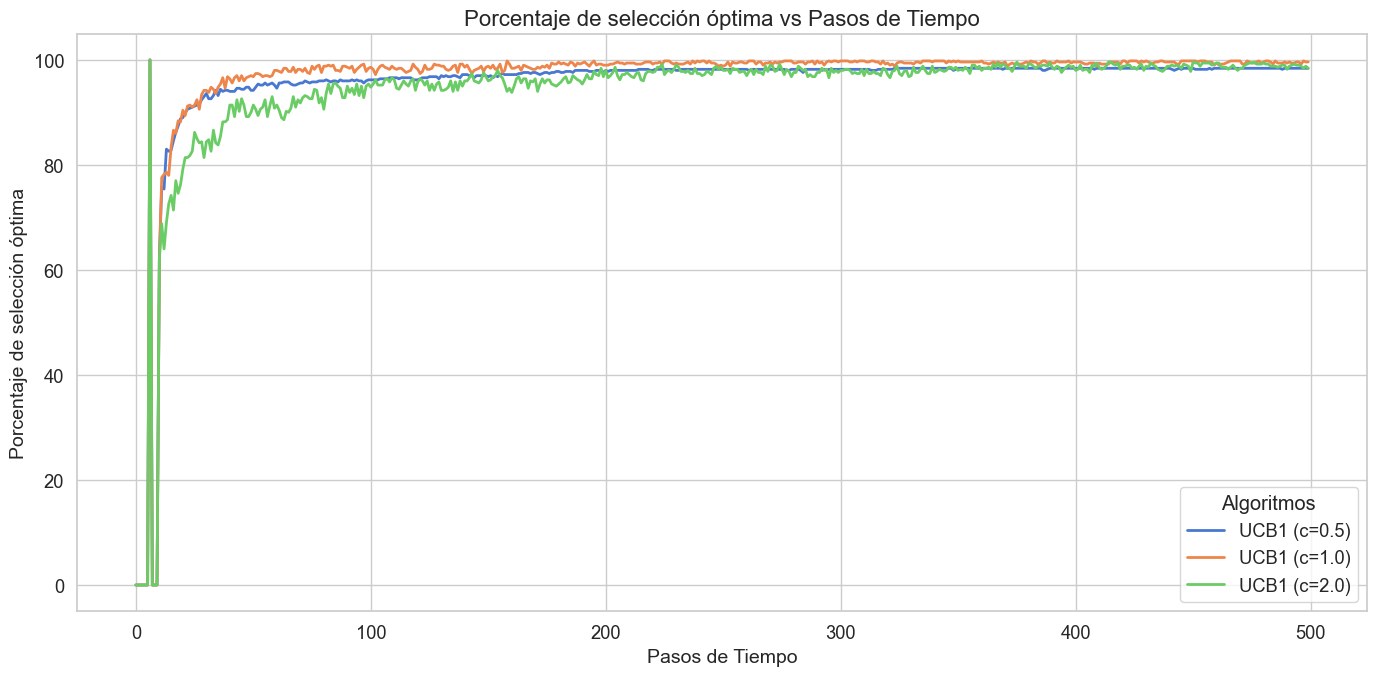

In [12]:
plot_optimal_selections(steps, optimal_selections_UCB1, ucb1_algorithms)

A niveles generales, podemos observar la siguiente progresión de la gráfica:

- Al inicio (steps bajos), los porcentajes de selección óptima son demasiado diferenciados, sin una progresión definida, lo cual refleja la exploración inicial del algoritmo.

- A medida que aumentan los pasos de tiempo, todas las curvas crecen rápidamente y se estabilizan cerca del 100%, indicando que los algoritmos identifican y explotan el brazo óptimo a largo plazo.

**Resultados por algoritmo**

- UCB1 con c=0.5 (Azul): Tiene un ascenso rápido hacia valores altos de porcentaje de selección óptima. Alrededor del paso 100 ya supera el 90% de selección óptima, mostrando que este valor de c facilita una explotación temprana y efectiva del brazo óptimo. Sin embargo, queda siempre ligeramente por debajo de la línea naranja, entendiendo entonces por qué el regret acumulado es algo superior a dicha variante del algoritmo.

- UCB1 con c=1.0 (Naranja): Exhibe el mejor comportamiento, con una curva que asciende a un ritmo alto. Para los 200 pasos de tiempo, se estabiliza cerca del 100%, lo que sugiere un balance óptimo entre exploración y explotación. Ofrece un rendimiento similar al de la línea azul al principio, pero luego siempre queda por encima.

- UCB1 con c=2.0 (Verde): La curva tiene el ascenso más lento al inicio, lo que indica una mayor exploración temprana. Aunque eventualmente alcanza el 100% de selección del brazo óptimo, lo hace más tarde (aproximadamente después de los 400 pasos), lo que sugiere que un c alto retrasa la explotación.

Podemos decir, entonces, que la elección del brazo óptimo tiene una influencia ligeramente notable en la diferencia que presentan las variantes con valor 0.5 y 1.0, haciendo que la segunda sea algo mejor.

# UCB2

In [13]:
# Definir los algoritmos a comparar. Ahora usamos el otro algoritmo pedido de la familia UCB: UCB2, con diferentes valores del parámetro de ajuste de exploración alpha.
ucb2_algorithms = [UCB2(k, alpha=0.01), UCB2(k, alpha=0.1), UCB2(k, alpha=0.9)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_UCB2, optimal_selections_UCB2, arm_stats_UCB2, regret_accumulated_UCB2 = run_experiment(bandit, ucb2_algorithms, steps, runs)

## Recompensa promedio

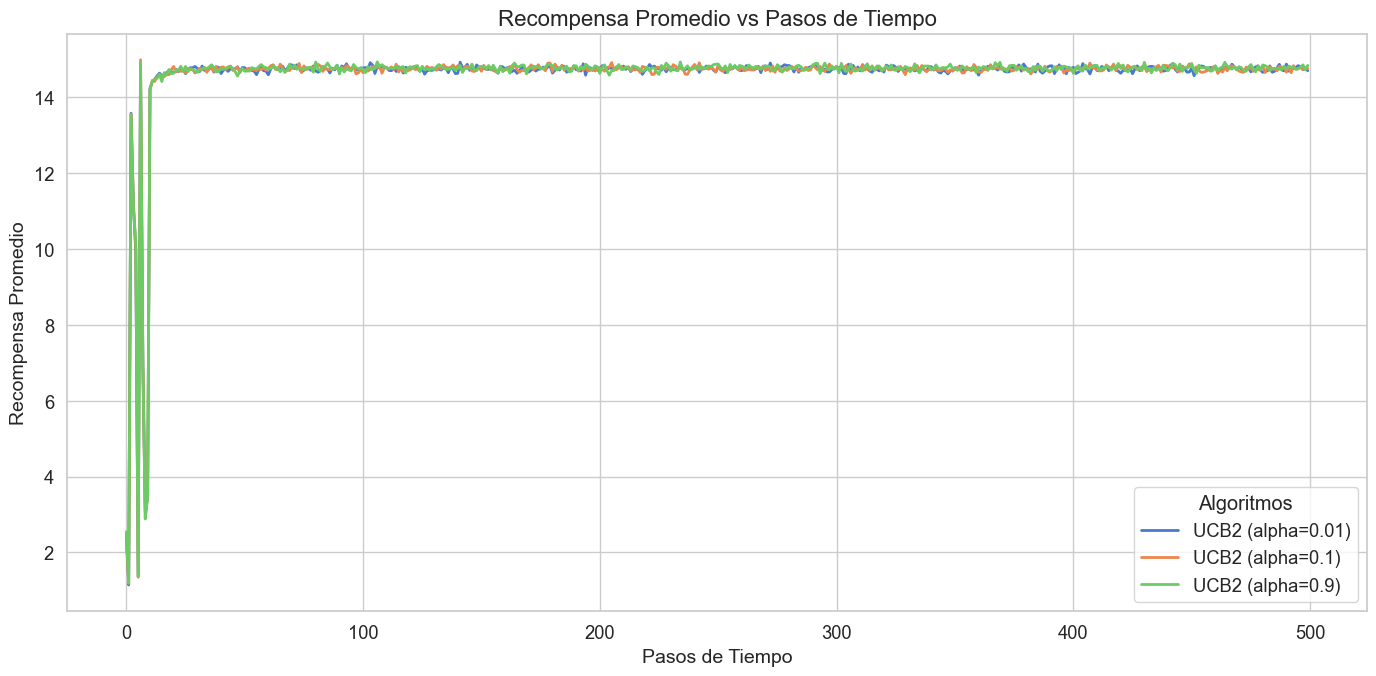

In [14]:
plot_average_rewards(steps, rewards_UCB2, ucb2_algorithms)

La gráfica que mostramos en este apartado es similar a la mostrada para UCB1, pero variando el valor de alpha en el algoritmo UCB2.

A nivel general, podemos ver que, al inicio, todas las curvas comienzan en un nivel muy irregular de recompensa promedio debido a la exploración inicial, pero rápidamente crecen al hallar el brazo óptimo y explotarlo, sobre los primeros pasos. Con el tiempo, las líneas tienden a estabilizarse hacia un valor rondando el 14.5, que es el de la recompensa del brazo óptimo del bandido, reflejando la capacidad del algoritmo para identificar y explotar el brazo con mayor recompensa.

En este apartado no incluiremos resultados por algoritmo debido a que las tres variantes presentan un rendimiento tan parecido que señalar diferencias es imposible a nivel visual, y por tanto, podemos concluir que los tres algoritmos obtienen resultados prácticamente iguales en cuanto a la recompensa promedio obtenida.

## Regret acumulado

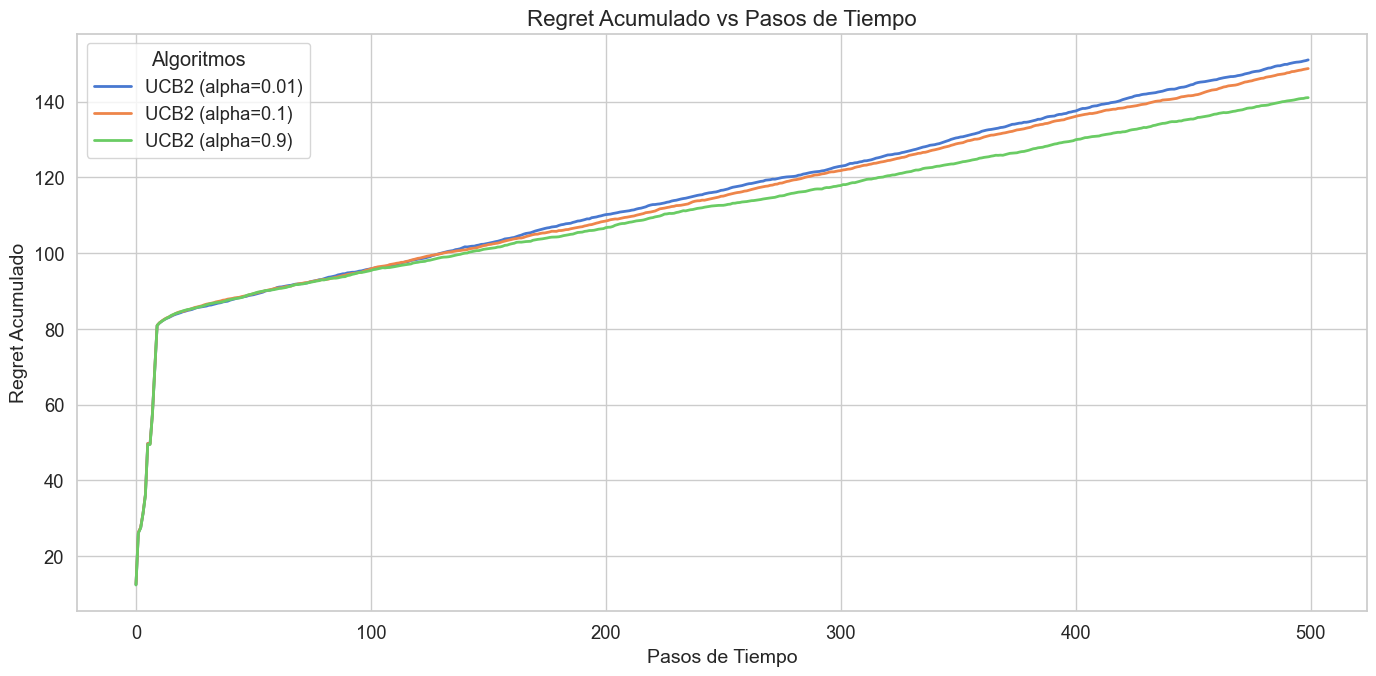

In [15]:
plot_regret(steps, regret_accumulated_UCB2, ucb2_algorithms)

En este apartado, la gráfica refleja el regret acumulado por cada variante a lo largo del tiempo, que muestra la cantidad de oportunidad perdida con las elecciones tomadas por el algoritmo, como se indica en el apartado de UCB1. 

A nivel general, podemos observar una tendencia prácticamente idéntica entre las tres líneas, especialmente hasta la mitad del espacio entre el paso 100 y el 200. A partir de ahí, vemos como, aunque la tendencia es ascendente para todas, se comienza a ver bastante espacio entre ellas y permite hallar una mayor diferencia visual.

**Resultados por algoritmo**

- UCB2 con &alpha;=0.01 (Azul) y &alpha;=0.1 (Naranja): Muestran el mayor regret con una pequeñísima diferencia en favor de la línea naranja. Su crecimiento crece de de manera moderada y consistente con el tiempo, al igual que el mayor valor de alpha.

- UCB2 con &alpha;=0.9 (Verde): Crece de una manera prácticamente idéntica desde el inicio en comparación con las otras dos variantes. Sin embargo, su crecimiento tiene una tendencia algo más lenta, notándose más conforme avanza la gráfica sobre el eje horizontal.

Como conclusión de esta gráfica, podemos decir que el resultado de la línea verde sobre las otras dos indica que un alto nivel de exploración favorece el aprovechamiento de oportunidades, pero con una diferencia mínima.

## Optimal selections

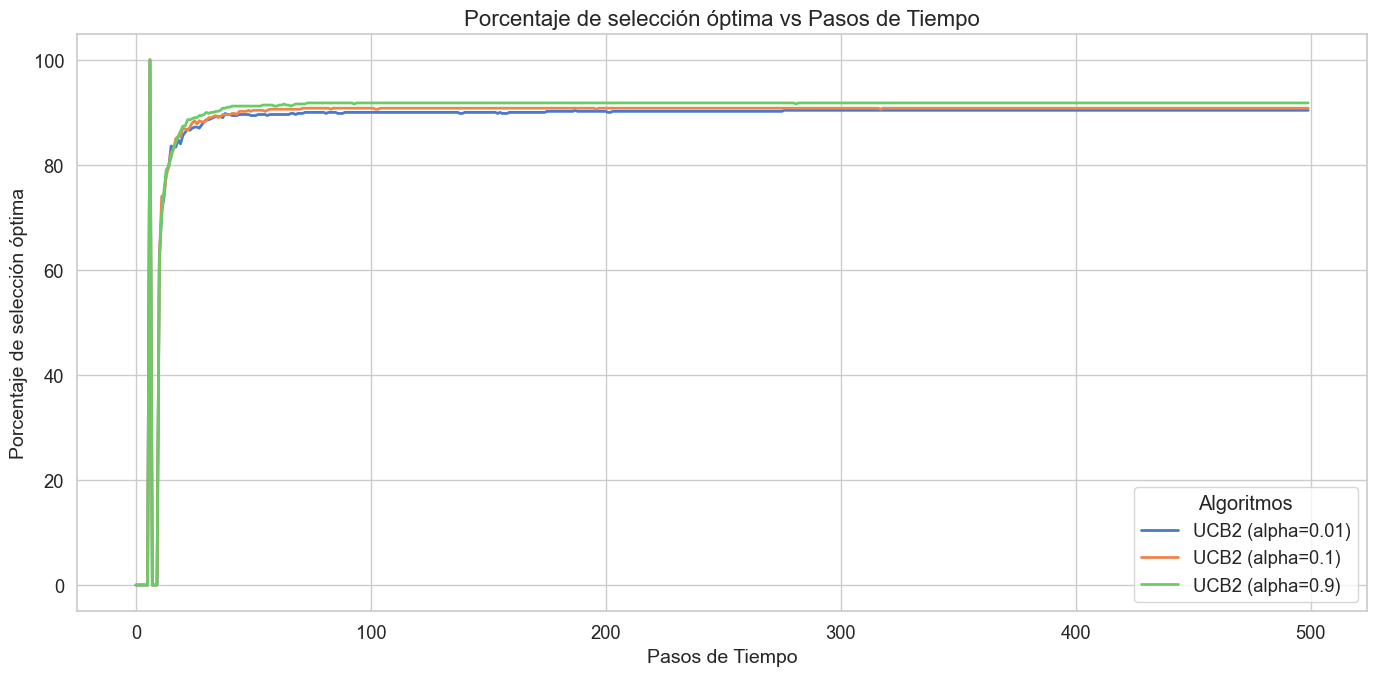

In [16]:
plot_optimal_selections(steps, optimal_selections_UCB2, ucb2_algorithms)

La gráfica que mostramos en este apartado es la correspondiente a la del porcentaje de veces que se selecciona el brazo que ofrece una mejor recompensa.

A nivel general, podemos ver que, a pesar de las irregularidades de los primeros pasos, las tres gráficas presentan una curva exactamente igual, con una separación mínima que refleja una diferencia prácticamente nula en cuanto a valor porcentual. Podemos destacar que la línea verde es milimétricamente superior, pero no es una diferencia concluyente.

Al igual que ocurrió con la gráfica de la recompensa promedio, en este apartado no incluiremos resultados por algoritmo debido a los rendimientos tan similares que presentan las tres variantes. Sin embargo, sí que mencionaremos que, dada la diferencia presentada en este apartado y en el de regret, especialmente el segundo, podemos concluir que un mayor valor de exploración mejora los resultados, aunque sea mínimamente.

# UCB1 vs UCB2

## Recompensa promedio

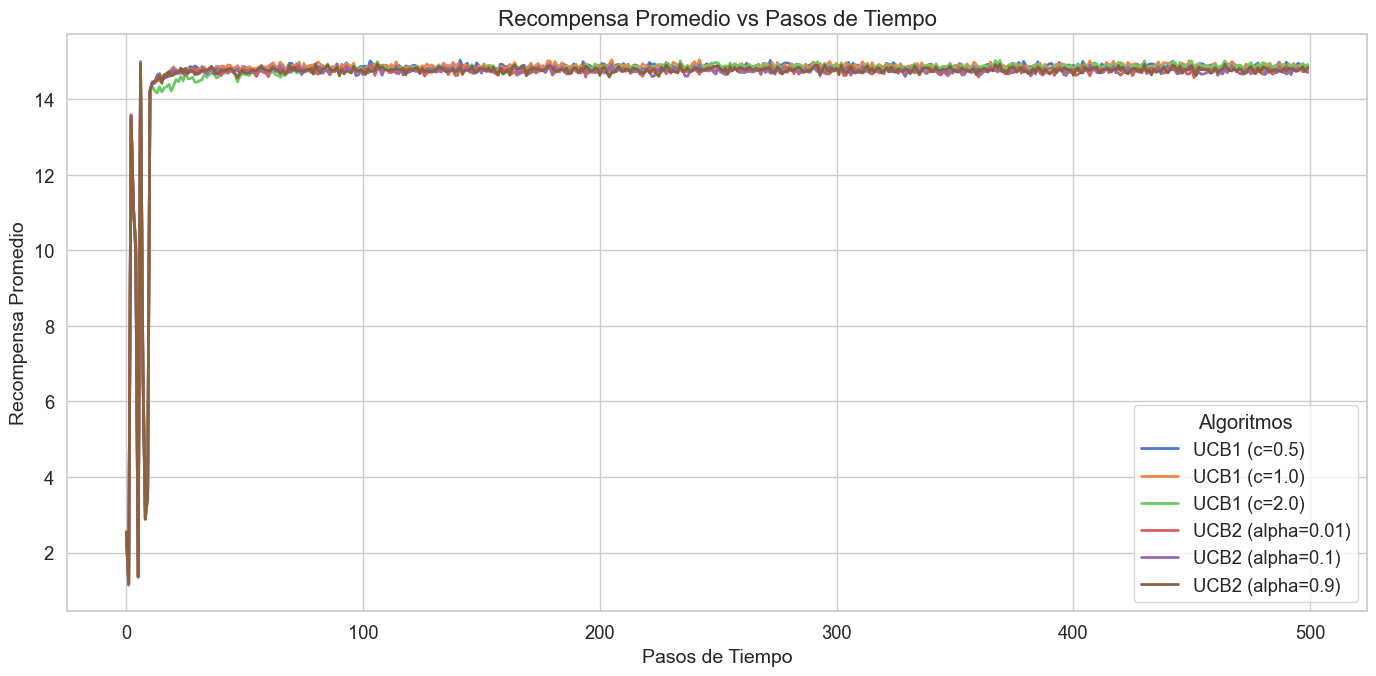

In [17]:
plot_average_rewards(steps, np.vstack((rewards_UCB1, rewards_UCB2)), ucb1_algorithms+ucb2_algorithms)

Si pasamos a comentar las gráficas superpuestas, podemos observar que, en lo que respecta a la comparación de algoritmos sobre la recompensa promedio obtenida, ambos algoritmos, en todas sus versiones, obtienen un resultado idéntico, alcanzando una recompensa promedio excelente casi en los primeros pasos de tiempo, lo que indica que la diferencia a la hora de explorar y explotar el brazo óptimo no es casi relevante para la distribución binomial, ya que al haber un rango mayor de recompensas que en la distribución Bernoulli [1-15 presentado en nuestro caso de binomial, 0-1 en la Bernoulli], es más fácil elegir las mejores opciones ya que hay mayor diferencia entre las recompensas ofrecidas. Por ello, podemos decir que los algoritmos tienen un muy buen rendimiento en cuanto a obtención de recompensas se refiere.

## Regret acumulado

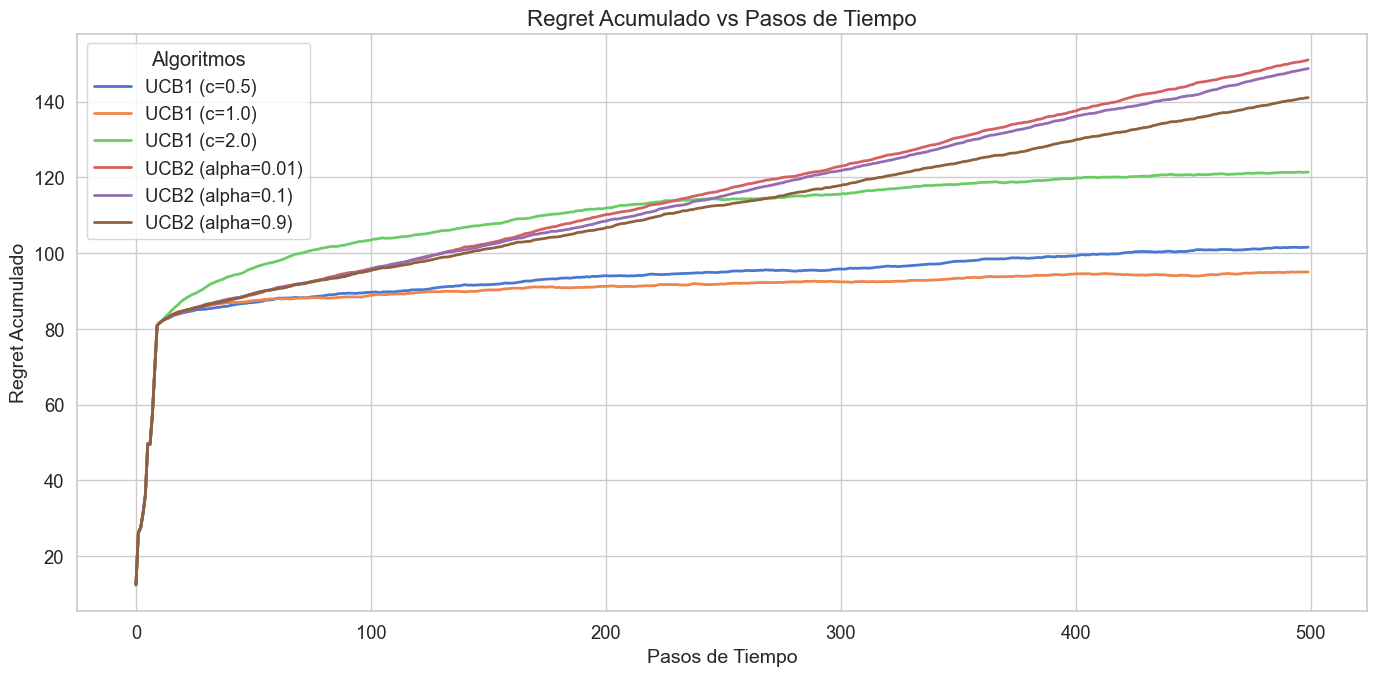

In [18]:
plot_regret(steps, np.vstack((regret_accumulated_UCB1, regret_accumulated_UCB2)), ucb1_algorithms+ucb2_algorithms)

El caso es diferente para la gráfica del regret. Aquí, vemos un claro predominio de UCB1, donde sus tres variantes son mucho mejores en el largo plazo que las de UCB2, ya que su tendencia es casi recta respecto a la diagonal presentada por las variantes de este último. Lo que nos indica este resultado es que, al utilizar un número de ejecuciones fijo por cada paso, lo hace más rígido a la hora de perder oportunidades de aplicar una ejecución o acción mejor y, por tanto, acumular una mayor cantidad de regret o pérdida de oportunidades.

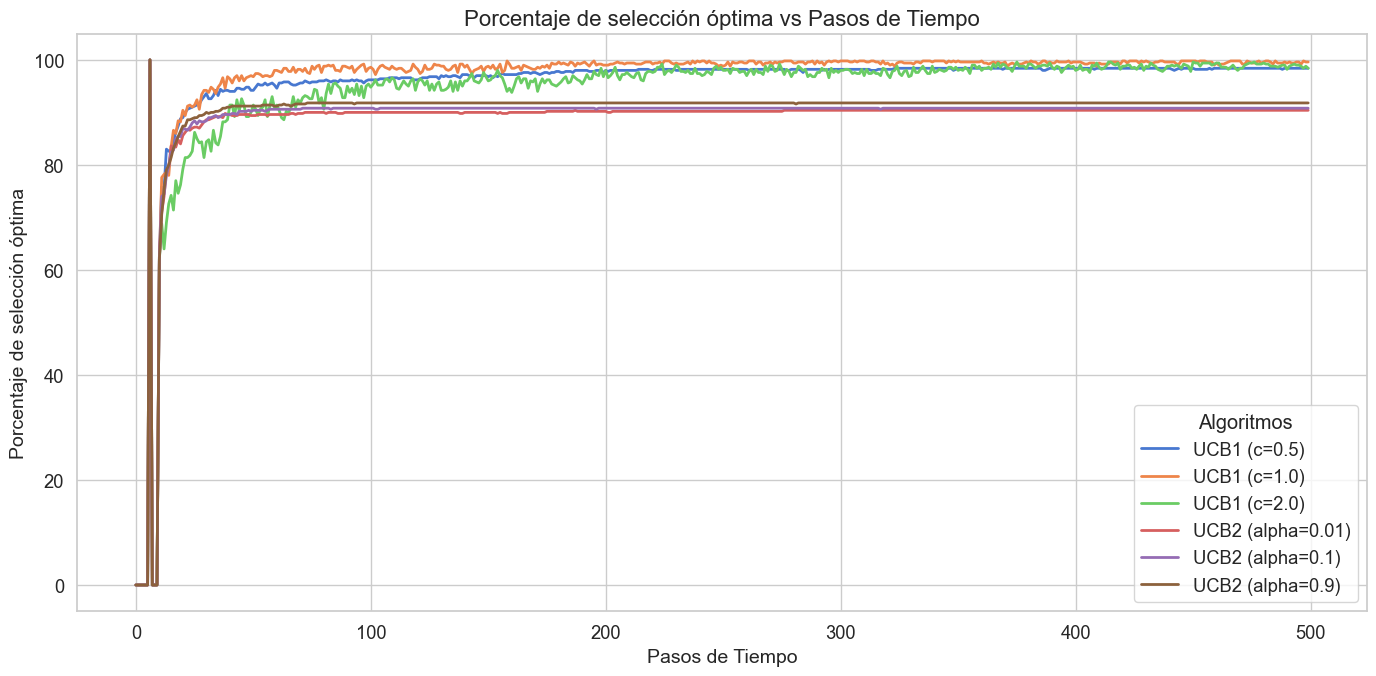

In [19]:
plot_optimal_selections(steps, np.vstack((optimal_selections_UCB1, optimal_selections_UCB2)), ucb1_algorithms+ucb2_algorithms)

En lo que respecta a la gráfica de selección del brazo óptimo, se repite una situación similar a la de la recompensa promedio, pero con una diferencia clara. En el caso de UCB1, la curvatura es similar para sus variantes excepto la de mayor valor exploratorio (c), pero todas acaban convergiendo hacia un valor bastante mejor (cerca del 100%) que sus competidoras de UCB2, que se quedan en un sólido 90% más o menos. Ambas gráficas son prácticamente similares en cuanto a tendencia, ya que una vez alcanzan su punto óptimo, se mantienen en él, donde UCB2 llega antes pero es un valor bastante inferior al de UCB1. Esto, relacionado con las líneas de recompensa promedio, nos indica que UCB2 elige menos veces el brazo óptimo, lastrándole que escoge peores brazos a la hora de equivocarse, mientras que UCB1 tiende a quedarse con un brazo mejor cuando se equivoca.

Por todo esto que hemos mencionado, podemos concluir que, a pesar de que en cuanto a recompensas promedio obtenidas los algoritmos obtengan un rendimiento idéntico, el desperdicio de un mayor volumen de oportunidades y una selección óptima inferior, UCB1 es mejor a la hora de rendir en el experimento realizado sobre la distribución binomial, aunque con una diferencia no demasiado grande.